## Use new harmonized data file 

From request [Rerun machine learning using the attached spreadsheet.](https://trello.com/c/IoUEsHsC)

## Imports and Function Definitions

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import itertools

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support, roc_curve, make_scorer, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold, train_test_split, LeaveOneOut, GridSearchCV, cross_validate
from sklearn.svm import SVC

from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

def plot_confusion_matrix(cm, classes=[0,1],
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def grid_search_optimization(model, tuned_parameters, X, y, Xh, yh, cv=5, scoring='accuracy', verbose=False):
    print("# Tuning hyper-parameters for %s" %scoring)
    print()

    clf = GridSearchCV(model, tuned_parameters, cv=cv, n_jobs = -1, scoring=scoring, verbose=1)
    clf.fit(X, y)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    if verbose:
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()

    print("Detailed classification report (holdout):")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = yh, clf.predict(Xh)
    print(classification_report(y_true, y_pred))
    print()
    plot_confusion_matrix(confusion_matrix(y_true, y_pred)) 
    print()
    get_metrics(clf.best_estimator_, Xh, yh)
    
    print("TRAINNG PROBABILITIES")
    for a,b in zip(y, clf.predict_proba(X)[:,1]):
        print(a,b)
    
    return clf

def group_classes(data, grouping):
        classes_to_keep = grouping.keys()
        data_to_keep = data.loc[data['GroupID'].isin(classes_to_keep)]
        classes_to_change = {k:grouping[k] for k in classes_to_keep if k!= grouping[k]}
        return data_to_keep.replace(classes_to_change)
    
def plot_coefficients(classifier, feature_names, top_features=20):
     coef = classifier.coef_.ravel()
     top_positive_coefficients = np.argsort(coef)[-top_features:]
     top_negative_coefficients = np.argsort(coef)[:top_features]
     top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
     # create plot
     plt.figure(figsize=(15, 5))
     colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
     plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
     feature_names = np.array(feature_names)
     plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
     plt.show()
        
def print_feature_importance(feature_names, coefs):
    assert len(feature_names) == len(coefs), "Arrays have difference lengths. Something went wrong"
    for feature, coef in zip(feature_names, coefs):
        print("%s\t%s" %(feature, coef))
        
# AKA True Negative Rate
def specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return cm[0,0] / cm[0,:].sum()

def negative_predictive_value(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return cm[0,0] / cm[:,0].sum()

def get_weighted_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn = cm[0,0]
    tp = cm[1,1]
    fp = cm[0,1]
    fn = cm[1,0]
    
    tnw = tn / (tn + fp)
    tpw = tp / (tp + fn)
    fpw = fp / (tn + fp)
    fnw = fn / (tp + fn)
    
    return tpw, fpw, fnw, tnw

def weighted_accuracy(y_true, y_pred):
    tpw, fpw, fnw, tnw = get_weighted_confusion_matrix(y_true, y_pred)
    
    return (tpw + tnw) / (tpw + fpw + fnw + tnw)
    
def weighted_sensitivity(y_true, y_pred):
    tpw, fpw, fnw, tnw = get_weighted_confusion_matrix(y_true, y_pred)

    return tpw / (tpw + fnw)
    
def weighted_specificity(y_true, y_pred):
    tpw, fpw, fnw, tnw = get_weighted_confusion_matrix(y_true, y_pred)

    return tnw / (tnw + fpw)
    
def weighted_ppv(y_true, y_pred):
    tpw, fpw, fnw, tnw = get_weighted_confusion_matrix(y_true, y_pred)
    
    return tpw / (tpw + fpw)

def weighted_npv(y_true, y_pred):
    tpw, fpw, fnw, tnw = get_weighted_confusion_matrix(y_true, y_pred)
    
    return tnw / (tnw + fnw)

def plot_roc(model, X_test, Y_test):
    y_true, y_pred = Y_test, model.predict(X_test)
    print(classification_report(y_true, y_pred))

    y_pred_prob = model.predict_proba(X_test)[:,1]

    fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)

    print("TESTING PROBABILITIES")
    for a,b in zip(Y_test,y_pred_prob):
        print(a,b)
    
    plt.plot([0,1],[0,1], 'k--')
    plt.plot(fpr, tpr, label='Linear SVC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Linear SVC ROC Curve')
    plt.show()
    
    for a,b in zip(fpr, tpr):
        print(a,b)
    
def get_metrics(model, X, y):
    for metric in _scoring_list:
        score = _scoring_list[metric](model, X, y)
        print("%s\t%s" %(metric, score))

## Define classifier, pipeline and constants

In [2]:
param_grid = {
    "classifier__C": np.logspace(-5, 10, 20),
#     "PCA__n_components": range(1,113,10),
#     "fss__k": range(1,115,3),
},

clf = Pipeline([
#     ('Norm', Normalizer()),\n",
#     ("Oversample", RandomOverSampler()),
#     ('PCA', PCA()),
    ('Scaler', StandardScaler()),
#     ('fss',SelectKBest()),
    ('classifier', SVC(kernel='linear', class_weight='balanced', probability=True))
])

_cv=5
_test_size=0.20
_scoring_list={
    'recall':make_scorer(recall_score),
    'precision':make_scorer(precision_score),
    'auc':make_scorer(roc_auc_score),
    'specificity':make_scorer(specificity),
    'npv':make_scorer(negative_predictive_value),
    'accuracy':make_scorer(accuracy_score),
    'weighted_sensitivity':make_scorer(weighted_sensitivity),
    'weighted_ppv':make_scorer(weighted_ppv),
    'weighted_specificity':make_scorer(weighted_specificity),
    'weighted_npv':make_scorer(weighted_npv),
    'weighted_accuracy':make_scorer(weighted_accuracy)
}

_scoring='f1_micro'
_data = pd.read_excel('Harmonized_Data.xlsx')
_random_seed = 55

## 1. Control vs. PD/MSA/PSP

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.2s finished


Best parameters set found on development set:

{'classifier__C': 0.088586679041008323}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.82      0.96      0.88        55
          1       0.99      0.92      0.95       146

avg / total       0.94      0.93      0.93       201


Confusion matrix, without normalization
[[ 53   2]
 [ 12 134]]

recall	0.917808219178
precision	0.985294117647
auc	0.940722291407
specificity	0.963636363636
npv	0.815384615385
accuracy	0.930348258706
weighted_sensitivity	0.917808219178
weighted_ppv	0.961889845993
weighted_specificity	0.963636363636
weighted_npv	0.92140985949
weighted_accuracy	0.940722291407
TRAINNG PROBABILITIES
1 0.995593929408
1 0.948780229126
1 0.999999999831
1 0.999998583923
1 0.958376777679
0 0.0611283519159
1 0.999987602802
1 0.999989168609
0 0.0455928406843
0 0.991842912

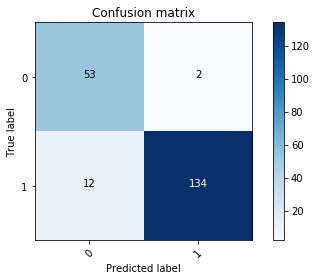

In [3]:
# Get the data
data1 = group_classes(_data, {0:0, 1:1, 2:1, 3:1})

y1 = data1['GroupID']
X1 = data1.drop(['GroupID'], axis=1)

X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X1, y1, test_size=_test_size, random_state=_random_seed)

best1 = grid_search_optimization(clf, param_grid, X_train1, Y_train1, X_test1, Y_test1, cv=_cv, scoring=_scoring)

In [4]:
scores = cross_validate(best1.best_estimator_, X_train1, Y_train1, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.157218027115	0.0102174700405
score_time	0.0507377624512	0.00375704850198
test_recall	0.925607196402	0.0222091868088
train_recall	0.961067945733	0.008566436773
test_precision	0.976240849762	0.0126162091151
train_precision	0.991966415185	0.00225708660708
test_auc	0.93371268911	0.0241127544315
train_auc	0.970443583061	0.00539335388331
test_specificity	0.941818181818	0.0301196471353
train_specificity	0.979819220388	0.00570612926563
test_npv	0.831469068034	0.0452065944898
train_npv	0.906984909187	0.0186668592559
test_accuracy	0.930106644791	0.0226454855816
train_accuracy	0.966286993769	0.00654833965104
test_weighted_sensitivity	0.925607196402	0.0222091868088
train_weighted_sensitivity	0.961067945733	0.008566436773
test_weighted_ppv	0.941299177127	0.0297557532516
train_weighted_ppv	0.979459562956	0.00570588508776
test_weighted_specificity	0.941818181818	0.0301196471353
train_weighted_specificity	0.979819220388	0.00570612926563
test_weighted_npv	0.926789906657	0.0221550744043
train

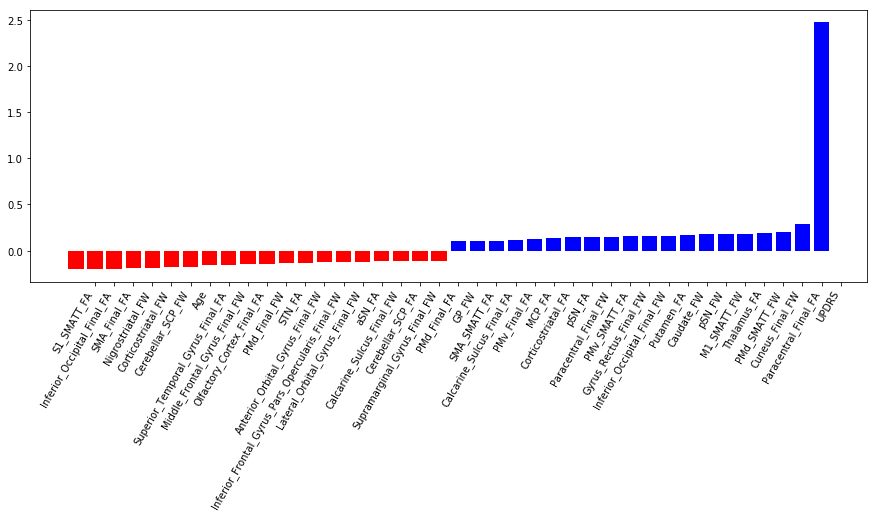

In [5]:
model = best1.best_estimator_.named_steps['classifier']
feature_names = data1.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

Age	-0.177642155166
Sex	-0.0430827425148
UPDRS	2.47470735242
aSN_FA	-0.117562625024
Caudate_FA	-0.0376278573271
CC2_FA	0.053449415768
GP_FA	-0.0320671291884
LobuleVI_FA	0.0768034520498
LobuleV_FA	-0.0642730561519
MCP_FA	0.12401682554
pSN_FA	0.147856473568
Putamen_FA	0.161013997588
SCP_FA	0.0398975723233
STN_FA	-0.136323824823
Thalamus_FA	0.177639537128
Vermis_FA	0.0603422838138
RN_FA	-0.0184247721951
PPN_FA	0.00459578543871
Dentate_FA	-0.0867963945544
CC1_FA	-0.00308359617754
aSN_FW	-0.030734710231
Caudate_FW	0.169667109082
CC2_FW	0.0385932723048
GP_FW	0.100052277863
LobuleVI_FW	0.0890052870018
LobuleV_FW	0.0109757909366
MCP_FW	-0.0511100113182
pSN_FW	0.175736951853
Putamen_FW	-0.0473835612303
SCP_FW	0.092844244077
STN_FW	0.0798568955734
Thalamus_FW	-0.0850069847154
Vermis_FW	-0.0105943854754
RN_FW	-0.0665079845298
PPN_FW	-0.0453755286269
Dentate_FW	0.0224855318092
CC1_FW	0.0621053429723
Angular_Gyrus_Final_FA	0.0910473193168
Anterior_Orbital_Gyrus_Final_FA	0.00444466820285
Calcarine_S

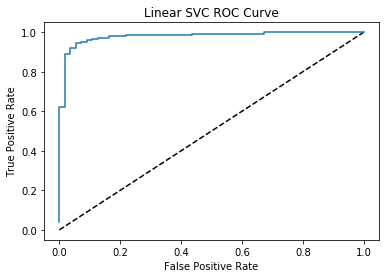

0.0 0.041095890411
0.0 0.623287671233
0.0181818181818 0.623287671233
0.0181818181818 0.890410958904
0.0363636363636 0.890410958904
0.0363636363636 0.917808219178
0.0545454545455 0.917808219178
0.0545454545455 0.945205479452
0.0727272727273 0.945205479452
0.0727272727273 0.952054794521
0.0909090909091 0.952054794521
0.0909090909091 0.958904109589
0.109090909091 0.958904109589
0.109090909091 0.965753424658
0.127272727273 0.965753424658
0.127272727273 0.972602739726
0.163636363636 0.972602739726
0.163636363636 0.979452054795
0.218181818182 0.979452054795
0.218181818182 0.986301369863
0.436363636364 0.986301369863
0.436363636364 0.993150684932
0.672727272727 0.993150684932
0.672727272727 1.0
1.0 1.0


In [6]:
plot_roc(best1.best_estimator_, X_test1, Y_test1)

## 2. PD vs MSA/PSP

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   45.7s finished


Best parameters set found on development set:

{'classifier__C': 0.0023357214690901212}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.93      0.90      0.91       105
          1       0.75      0.82      0.79        40

avg / total       0.88      0.88      0.88       145


Confusion matrix, without normalization
[[94 11]
 [ 7 33]]

recall	0.825
precision	0.75
auc	0.860119047619
specificity	0.895238095238
npv	0.930693069307
accuracy	0.875862068966
weighted_sensitivity	0.825
weighted_ppv	0.887323943662
weighted_specificity	0.895238095238
weighted_npv	0.836484983315
weighted_accuracy	0.860119047619
TRAINNG PROBABILITIES
0 0.1478266821
0 0.391118868896
0 0.191767628788
1 0.250206336954
0 0.162137100793
1 0.832435301772
0 0.547390209469
1 0.904366063769
0 0.0304700773025
0 0.0416850676903
0 0.161210237509
0 0.0521504

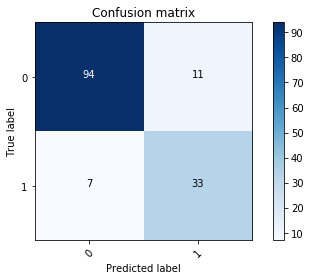

In [7]:
# Get the data
data2 = group_classes(_data, {1:0, 2:1, 3:1})

y2 = data2['GroupID']
X2 = data2.drop(['GroupID'], axis=1)

X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X2, y2, test_size=_test_size, random_state=_random_seed)

best2 = grid_search_optimization(clf, param_grid, X_train2, Y_train2, X_test2, Y_test2, cv=_cv, scoring=_scoring)

In [8]:
scores = cross_validate(best2.best_estimator_, X_train2, Y_train2, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.398600292206	0.0698800463274
score_time	0.207305049896	0.0768667297549
test_recall	0.716638655462	0.0230650455873
train_recall	0.757209884266	0.0280876489611
test_precision	0.765024630542	0.0705022774687
train_precision	0.807876286361	0.024948786717
test_auc	0.810276569526	0.0238183671671
train_auc	0.840119661981	0.0155407109077
test_specificity	0.903914483589	0.0326367150041
train_specificity	0.923029439696	0.0116764883262
test_npv	0.882083550942	0.00982846171821
train_npv	0.899325330923	0.0106116333993
test_accuracy	0.847941670191	0.0263581418727
train_accuracy	0.873486960273	0.0120486370071
test_weighted_sensitivity	0.716638655462	0.0230650455873
train_weighted_sensitivity	0.757209884266	0.0280876489611
test_weighted_ppv	0.882709178199	0.0378273105952
train_weighted_ppv	0.907781473707	0.0134984209117
test_weighted_specificity	0.903914483589	0.0326367150041
train_weighted_specificity	0.923029439696	0.0116764883262
test_weighted_npv	0.761320389498	0.0182759702791
train_weig

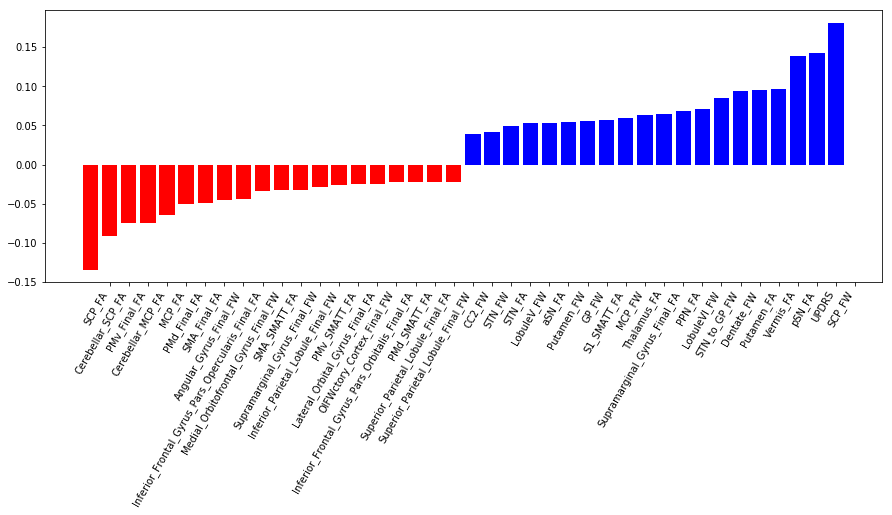

Age	0.0203581844165
Sex	0.0
UPDRS	0.14245379514
aSN_FA	0.0535187664329
Caudate_FA	-0.00560271661006
CC2_FA	0.00661950714431
GP_FA	0.0177923384454
LobuleVI_FA	0.0121335532869
LobuleV_FA	-0.00600769000887
MCP_FA	-0.0648523545542
pSN_FA	0.139266795381
Putamen_FA	0.0958904744198
SCP_FA	-0.134325080797
STN_FA	0.049924202335
Thalamus_FA	0.0628587019534
Vermis_FA	0.0964786346866
RN_FA	0.0282135031614
PPN_FA	0.0687829704325
Dentate_FA	0.0167641906837
CC1_FA	-0.0105974913299
aSN_FW	-0.00190300406086
Caudate_FW	0.00403817783762
CC2_FW	0.0386229453725
GP_FW	0.0561891790575
LobuleVI_FW	0.0714113304824
LobuleV_FW	0.0534818575537
MCP_FW	0.0594260071
pSN_FW	0.0378669816463
Putamen_FW	0.0538958438518
SCP_FW	0.181115720606
STN_FW	0.041330059917
Thalamus_FW	0.00462740399652
Vermis_FW	0.0323228996661
RN_FW	0.0299263489323
PPN_FW	-0.000520972124482
Dentate_FW	0.0939500014417
CC1_FW	-0.00619592972503
Angular_Gyrus_Final_FA	0.00279014999134
Anterior_Orbital_Gyrus_Final_FA	-0.000481405175981
Calcarine_Sulcus

In [9]:
model = best2.best_estimator_.named_steps['classifier']
feature_names = data2.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

             precision    recall  f1-score   support

          0       0.93      0.90      0.91       105
          1       0.75      0.82      0.79        40

avg / total       0.88      0.88      0.88       145

TESTING PROBABILITIES
1 0.143984327808
0 0.0148184298875
0 0.139054343005
0 0.120979334815
0 0.0654059560384
0 0.35607773313
0 0.169296927576
0 0.0335792138669
0 0.0511995063096
0 0.0235311016816
1 0.999994514904
0 0.0519184727989
1 0.693297629898
0 0.0340649938026
0 0.0191352121974
1 0.996543747785
1 0.992618578391
0 0.466081238037
0 0.142472749325
1 0.438255931991
0 0.129159850197
0 0.0760793902972
0 0.10872427652
0 0.203085236943
0 0.0308792353487
1 0.965623231992
1 0.558855534095
0 0.113797486819
0 0.300421441001
0 0.334564384338
0 0.0330326907898
1 0.86979731896
1 0.822226248406
1 0.337238570889
1 0.911847418713
1 0.946492624462
0 0.074147189544
1 0.847363700693
1 0.999991762276
0 0.053022212733
0 0.520437398407
0 0.184919007215
0 0.0996221381664
0 0.232437318158
0 0.07

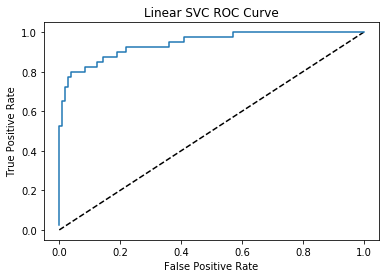

0.0 0.025
0.0 0.525
0.00952380952381 0.525
0.00952380952381 0.65
0.0190476190476 0.65
0.0190476190476 0.725
0.0285714285714 0.725
0.0285714285714 0.775
0.0380952380952 0.775
0.0380952380952 0.8
0.0857142857143 0.8
0.0857142857143 0.825
0.12380952381 0.825
0.12380952381 0.85
0.142857142857 0.85
0.142857142857 0.875
0.190476190476 0.875
0.190476190476 0.9
0.219047619048 0.9
0.219047619048 0.925
0.361904761905 0.925
0.361904761905 0.95
0.409523809524 0.95
0.409523809524 0.975
0.571428571429 0.975
0.571428571429 1.0
1.0 1.0


In [10]:
plot_roc(best2.best_estimator_, X_test2, Y_test2)

## 3. MSA vs PD/PSP

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   33.4s finished


Best parameters set found on development set:

{'classifier__C': 0.0023357214690901212}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.97      0.89      0.93       131
          1       0.42      0.79      0.55        14

avg / total       0.92      0.88      0.89       145


Confusion matrix, without normalization
[[116  15]
 [  3  11]]

recall	0.785714285714
precision	0.423076923077
auc	0.83560523446
specificity	0.885496183206
npv	0.974789915966
accuracy	0.875862068966
weighted_sensitivity	0.785714285714
weighted_ppv	0.872804360993
weighted_specificity	0.885496183206
weighted_npv	0.805156172533
weighted_accuracy	0.83560523446
TRAINNG PROBABILITIES
0 0.153573168155
0 0.078604044672
0 0.066133281682
1 0.142267157427
0 0.0768612237791
0 0.0614920115515
0 0.0508849929125
1 0.11979445067
0 0.0405981482754
0 0.04784721

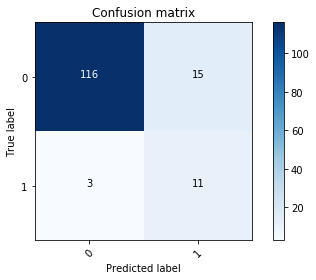

In [11]:
# Get the data
data3 = group_classes(_data, {1:0, 3:0, 2:1})

y3 = data3['GroupID']
X3 = data3.drop(['GroupID'], axis=1)

X_train3, X_test3, Y_train3, Y_test3 = train_test_split(X3, y3, test_size=_test_size, random_state=_random_seed)

best3 = grid_search_optimization(clf, param_grid, X_train3, Y_train3, X_test3, Y_test3, cv=_cv, scoring=_scoring)

In [12]:
scores = cross_validate(best3.best_estimator_, X_train3, Y_train3, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.312495517731	0.0679815795529
score_time	0.188800764084	0.0526009396963
test_recall	0.5	0.0782460796436
train_recall	0.653571428571	0.0242226070826
test_precision	0.514358974359	0.0555848706351
train_precision	0.646890123674	0.0351984401769
test_auc	0.717569403999	0.0384852935608
train_auc	0.801979624774	0.00984180085505
test_specificity	0.935138807998	0.0102137867471
train_specificity	0.950387820976	0.00844941975902
test_npv	0.931636135981	0.0097161882034
train_npv	0.95228801389	0.00293692025532
test_accuracy	0.882548725637	0.0117628971626
train_accuracy	0.914504356893	0.00593567017155
test_weighted_sensitivity	0.5	0.0782460796436
train_weighted_sensitivity	0.653571428571	0.0242226070826
test_weighted_ppv	0.883061356059	0.0243973310104
train_weighted_ppv	0.929735987298	0.00992671273778
test_weighted_specificity	0.935138807998	0.0102137867471
train_weighted_specificity	0.950387820976	0.00844941975902
test_weighted_npv	0.65347090915	0.0336124592822
train_weighted_npv	0.7331484

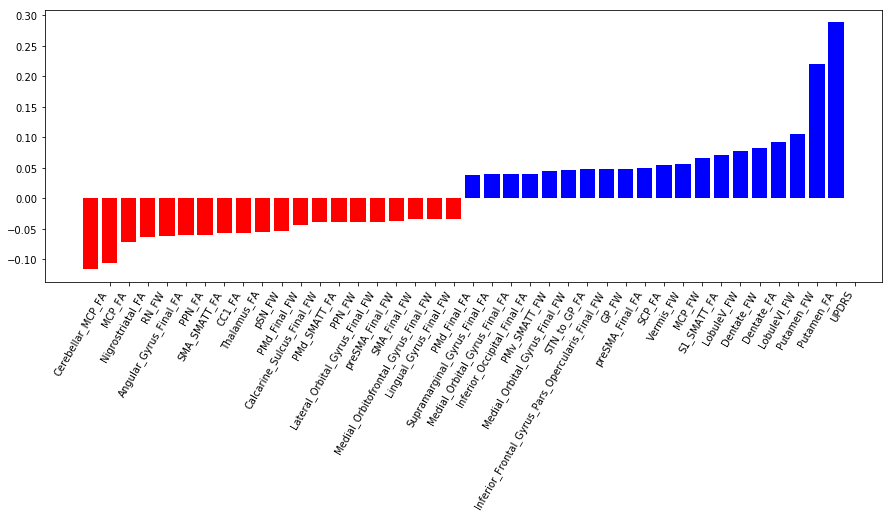

Age	0.0120360683117
Sex	0.0
UPDRS	0.289058079222
aSN_FA	-0.0187381816408
Caudate_FA	0.0032496755276
CC2_FA	0.0063586171329
GP_FA	0.0371250682247
LobuleVI_FA	-0.0238452309596
LobuleV_FA	0.00138959064233
MCP_FA	-0.105535067466
pSN_FA	0.0155019410462
Putamen_FA	0.219679676462
SCP_FA	0.0493699731506
STN_FA	-0.012574440777
Thalamus_FA	-0.0560906774859
Vermis_FA	0.00509513976362
RN_FA	-0.022327004208
PPN_FA	-0.06068476324
Dentate_FA	0.0828842736698
CC1_FA	-0.0564686474067
aSN_FW	-0.0269915974995
Caudate_FW	-0.00646364458511
CC2_FW	-0.00829818590329
GP_FW	0.0474885023934
LobuleVI_FW	0.0931954880858
LobuleV_FW	0.0707296571697
MCP_FW	0.0562508575361
pSN_FW	-0.0554971113011
Putamen_FW	0.106217252179
SCP_FW	0.00597517907594
STN_FW	-0.00311624548915
Thalamus_FW	-0.0190575573435
Vermis_FW	0.0549055045696
RN_FW	-0.0638368821041
PPN_FW	-0.0391903799033
Dentate_FW	0.0770920470245
CC1_FW	-0.0142920823786
Angular_Gyrus_Final_FA	-0.0620833431187
Anterior_Orbital_Gyrus_Final_FA	0.00707334451486
Calcarine_

In [13]:
model = best3.best_estimator_.named_steps['classifier']
feature_names = data3.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

             precision    recall  f1-score   support

          0       0.97      0.89      0.93       131
          1       0.42      0.79      0.55        14

avg / total       0.92      0.88      0.89       145

TESTING PROBABILITIES
1 0.0400171403195
0 0.0257128287145
0 0.0526648158916
0 0.144678626786
0 0.0794176400883
0 0.402274993136
0 0.116926967641
0 0.0418841024332
0 0.0708798300321
0 0.0191841602328
0 0.356693872001
0 0.0208530476672
1 0.801128496675
0 0.0630003853958
0 0.0895533174789
1 0.984748643808
0 0.0913369024261
0 0.107029380669
0 0.0395884902082
0 0.179390249827
0 0.0825051523802
0 0.0339654965653
0 0.0980657504771
0 0.1050851564
0 0.0337910640441
0 0.0989737206563
0 0.343016694085
0 0.0965384704647
0 0.406783095778
0 0.180388357748
0 0.0789742075903
1 0.547637398988
0 0.263161364621
0 0.0440426957168
0 0.121505855927
1 0.645884690573
0 0.169064183929
1 0.679949996721
1 0.985027729916
0 0.111225532714
0 0.211398631426
0 0.188941711487
0 0.038624688383
0 0.1003974372

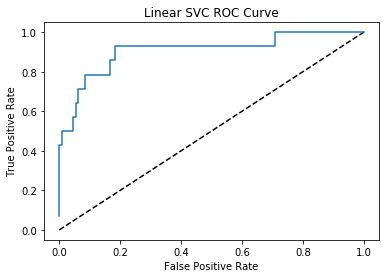

0.0 0.0714285714286
0.0 0.428571428571
0.00763358778626 0.428571428571
0.00763358778626 0.5
0.0458015267176 0.5
0.0458015267176 0.571428571429
0.0534351145038 0.571428571429
0.0534351145038 0.642857142857
0.0610687022901 0.642857142857
0.0610687022901 0.714285714286
0.0839694656489 0.714285714286
0.0839694656489 0.785714285714
0.167938931298 0.785714285714
0.167938931298 0.857142857143
0.18320610687 0.857142857143
0.18320610687 0.928571428571
0.709923664122 0.928571428571
0.709923664122 1.0
1.0 1.0


In [14]:
plot_roc(best3.best_estimator_, X_test3, Y_test3)

## 4. PSP vs PD/MSA

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.7s finished


Best parameters set found on development set:

{'classifier__C': 0.0023357214690901212}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.95      0.90      0.92       119
          1       0.62      0.77      0.69        26

avg / total       0.89      0.88      0.88       145


Confusion matrix, without normalization
[[107  12]
 [  6  20]]

recall	0.769230769231
precision	0.625
auc	0.834195216548
specificity	0.899159663866
npv	0.946902654867
accuracy	0.875862068966
weighted_sensitivity	0.769230769231
weighted_ppv	0.884101040119
weighted_specificity	0.899159663866
weighted_npv	0.795766590389
weighted_accuracy	0.834195216548
TRAINNG PROBABILITIES
0 0.0241401802261
0 0.148715784927
0 0.11173499996
0 0.0604620830058
0 0.0606421742087
1 0.745906127773
0 0.36771206146
0 0.840418071858
0 0.00705935170295
0 0.0166553059857
0

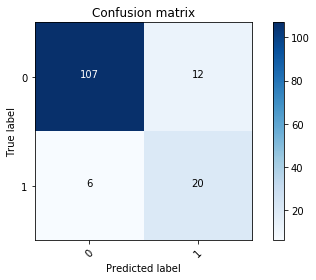

In [15]:
# Get the data
data4 = group_classes(_data, {1:0, 2:0, 3:1})

y4 = data4['GroupID']
X4 = data4.drop(['GroupID'], axis=1)

X_train4, X_test4, Y_train4, Y_test4 = train_test_split(X4, y4, test_size=_test_size, random_state=_random_seed)

best4 = grid_search_optimization(clf, param_grid, X_train4, Y_train4, X_test4, Y_test4, cv=_cv, scoring=_scoring)

In [16]:
scores = cross_validate(best4.best_estimator_, X_train4, Y_train4, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.125033664703	0.0211343431049
score_time	0.0634081840515	0.00479846117546
test_recall	0.806666666667	0.0505390444245
train_recall	0.859271231267	0.0159726008231
test_precision	0.752242424242	0.0750074546372
train_precision	0.785966513055	0.0243431777521
test_auc	0.873925438596	0.034567339818
train_auc	0.904165246798	0.00637225444311
test_specificity	0.941184210526	0.021651034918
train_specificity	0.949059262329	0.00803982057851
test_npv	0.957206150903	0.0118991270416
train_npv	0.96892776168	0.00337407102465
test_accuracy	0.917178590192	0.025753895355
train_accuracy	0.933079689048	0.00539750923291
test_weighted_sensitivity	0.806666666667	0.0505390444245
train_weighted_sensitivity	0.859271231267	0.0159726008231
test_weighted_ppv	0.93141737048	0.0261052901952
train_weighted_ppv	0.944173065048	0.00768597045601
test_weighted_specificity	0.941184210526	0.021651034918
train_weighted_specificity	0.949059262329	0.00803982057851
test_weighted_npv	0.830767587279	0.0410062864919
train_we

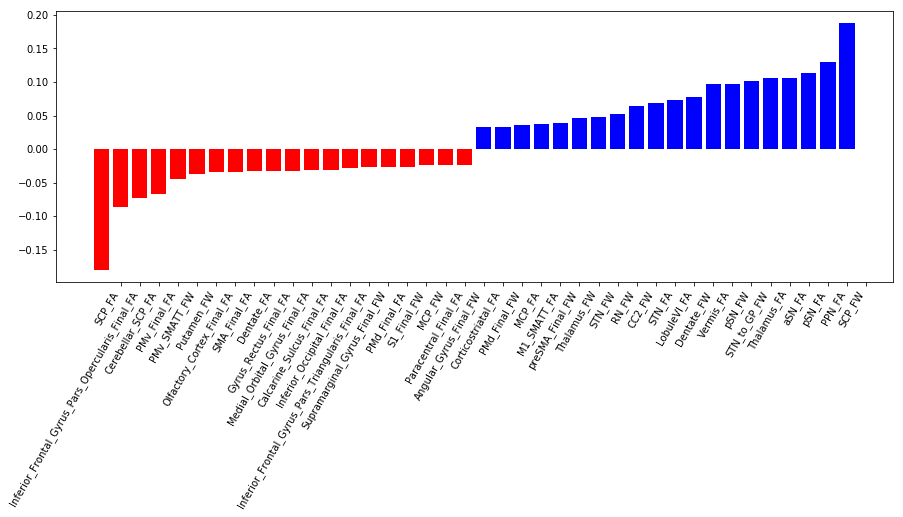

Age	0.0328048272276
Sex	0.0
UPDRS	-0.0111898897973
aSN_FA	0.106071930938
Caudate_FA	0.0130199828423
CC2_FA	0.0296611891925
GP_FA	-0.00289345008188
LobuleVI_FA	0.0732282452808
LobuleV_FA	-0.00688159348906
MCP_FA	0.036039202171
pSN_FA	0.112790063964
Putamen_FA	-0.0165264093357
SCP_FA	-0.180307671588
STN_FA	0.0682899743899
Thalamus_FA	0.105324947209
Vermis_FA	0.0964059760256
RN_FA	0.00206088801657
PPN_FA	0.129408205852
Dentate_FA	-0.0331534773308
CC1_FA	0.0219138215116
aSN_FW	-0.00238987910265
Caudate_FW	0.003913346566
CC2_FW	0.0636560396591
GP_FW	0.0106679571948
LobuleVI_FW	-0.000180718442587
LobuleV_FW	-0.0219745515327
MCP_FW	-0.0239401210879
pSN_FW	0.0976704951137
Putamen_FW	-0.0370445174532
SCP_FW	0.188021190781
STN_FW	0.0478205448126
Thalamus_FW	0.0461281104762
Vermis_FW	0.00869932801313
RN_FW	0.0520073833912
PPN_FW	0.0304751841298
Dentate_FW	0.0780327003369
CC1_FW	-0.00203741610087
Angular_Gyrus_Final_FA	0.0295325536304
Anterior_Orbital_Gyrus_Final_FA	-0.00329647573011
Calcarine_Sul

In [17]:
model = best4.best_estimator_.named_steps['classifier']
feature_names = data4.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

             precision    recall  f1-score   support

          0       0.95      0.90      0.92       119
          1       0.62      0.77      0.69        26

avg / total       0.89      0.88      0.88       145

TESTING PROBABILITIES
0 0.0814844375093
0 0.00605583681707
0 0.0425930037815
0 0.0125546613666
0 0.0120069270084
0 0.030270237423
0 0.037778143023
0 0.0134009698599
0 0.0107715279163
0 0.0271015106856
1 0.994610341597
0 0.035831812448
0 0.0133700914014
0 0.00911194334557
0 0.00216705102175
0 0.0936860376193
1 0.991284379797
0 0.151421760509
0 0.0758366275437
1 0.136335786245
0 0.0269673602651
0 0.0325030964724
0 0.0251121514095
0 0.0315669618727
0 0.0090601981512
1 0.954233567846
1 0.0840864398012
0 0.0193344278104
0 0.0316450978676
0 0.062552605431
0 0.00561607305807
0 0.153023889998
1 0.291236959052
1 0.204499371803
1 0.772831969025
0 0.14371815972
0 0.0113667322714
0 0.0961860474726
0 0.383994955107
0 0.0162280059463
0 0.122101916805
0 0.0246111032549
0 0.0320289613278
0 

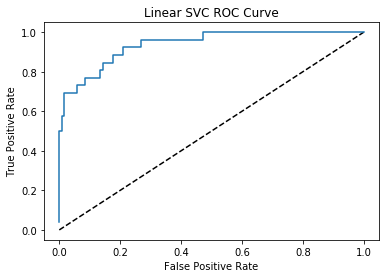

0.0 0.0384615384615
0.0 0.5
0.00840336134454 0.5
0.00840336134454 0.576923076923
0.0168067226891 0.576923076923
0.0168067226891 0.692307692308
0.0588235294118 0.692307692308
0.0588235294118 0.730769230769
0.0840336134454 0.730769230769
0.0840336134454 0.769230769231
0.134453781513 0.769230769231
0.134453781513 0.807692307692
0.142857142857 0.807692307692
0.142857142857 0.846153846154
0.176470588235 0.846153846154
0.176470588235 0.884615384615
0.210084033613 0.884615384615
0.210084033613 0.923076923077
0.268907563025 0.923076923077
0.268907563025 0.961538461538
0.470588235294 0.961538461538
0.470588235294 1.0
1.0 1.0


In [18]:
plot_roc(best4.best_estimator_, X_test4, Y_test4)

## 5. PSP (positive) vs MSA (negative)

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.6s finished


Best parameters set found on development set:

{'classifier__C': 0.01438449888287663}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.67      0.77      0.71        13
          1       0.89      0.83      0.86        30

avg / total       0.82      0.81      0.82        43


Confusion matrix, without normalization
[[10  3]
 [ 5 25]]

recall	0.833333333333
precision	0.892857142857
auc	0.801282051282
specificity	0.769230769231
npv	0.666666666667
accuracy	0.813953488372
weighted_sensitivity	0.833333333333
weighted_ppv	0.78313253012
weighted_specificity	0.769230769231
weighted_npv	0.821917808219
weighted_accuracy	0.801282051282
TRAINNG PROBABILITIES
1 0.805706357845
0 0.0969962190405
0 0.448421551311
1 0.915695694276
1 0.983686007129
1 0.915662762895
1 0.725936408478
0 0.143906771854
1 0.915639889313
1 0.765968913339
1 

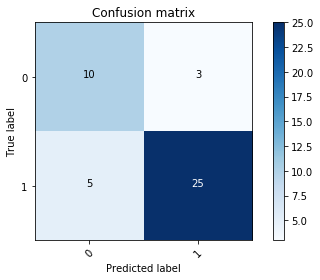

In [19]:
# Get the data
data5 = group_classes(_data, {2:0, 3:1})

y5 = data5['GroupID']
X5 = data5.drop(['GroupID'], axis=1)

X_train5, X_test5, Y_train5, Y_test5 = train_test_split(X5, y5, test_size=_test_size, random_state=_random_seed)

best5 = grid_search_optimization(clf, param_grid, X_train5, Y_train5, X_test5, Y_test5, cv=_cv, scoring=_scoring)

In [20]:
scores = cross_validate(best5.best_estimator_, X_train5, Y_train5, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.0128090381622	0.00206984526503
score_time	0.0140251636505	0.00322091278632
test_recall	0.858947368421	0.0729398492365
train_recall	0.891360759494	0.0262401888029
test_precision	0.897478734716	0.0388947406716
train_precision	0.969654147105	0.0107841514487
test_auc	0.859473684211	0.031554457027
train_auc	0.92628814917	0.0184327485878
test_specificity	0.86	0.0608779307219
train_specificity	0.961215538847	0.0133333568884
test_npv	0.821623931624	0.0747448480833
train_npv	0.864526069845	0.029870042236
test_accuracy	0.858604532722	0.0349967968453
train_accuracy	0.920532337834	0.019651753243
test_weighted_sensitivity	0.858947368421	0.0729398492365
train_weighted_sensitivity	0.891360759494	0.0262401888029
test_weighted_ppv	0.864173106504	0.0474551858299
train_weighted_ppv	0.958205818425	0.0148015357023
test_weighted_specificity	0.86	0.0608779307219
train_weighted_specificity	0.961215538847	0.0133333568884
test_weighted_npv	0.864900077428	0.057268242107
train_weighted_npv	0.8988103706

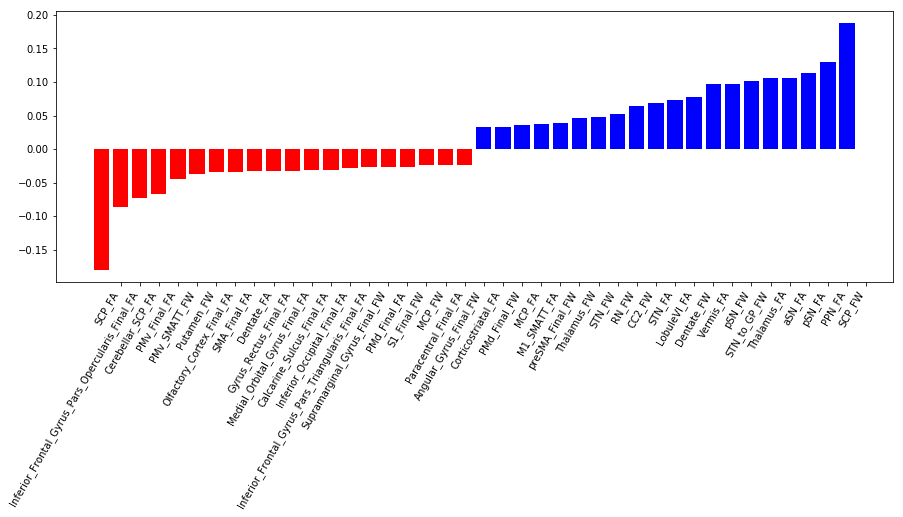

Age	0.0328048272276
Sex	0.0
UPDRS	-0.0111898897973
aSN_FA	0.106071930938
Caudate_FA	0.0130199828423
CC2_FA	0.0296611891925
GP_FA	-0.00289345008188
LobuleVI_FA	0.0732282452808
LobuleV_FA	-0.00688159348906
MCP_FA	0.036039202171
pSN_FA	0.112790063964
Putamen_FA	-0.0165264093357
SCP_FA	-0.180307671588
STN_FA	0.0682899743899
Thalamus_FA	0.105324947209
Vermis_FA	0.0964059760256
RN_FA	0.00206088801657
PPN_FA	0.129408205852
Dentate_FA	-0.0331534773308
CC1_FA	0.0219138215116
aSN_FW	-0.00238987910265
Caudate_FW	0.003913346566
CC2_FW	0.0636560396591
GP_FW	0.0106679571948
LobuleVI_FW	-0.000180718442587
LobuleV_FW	-0.0219745515327
MCP_FW	-0.0239401210879
pSN_FW	0.0976704951137
Putamen_FW	-0.0370445174532
SCP_FW	0.188021190781
STN_FW	0.0478205448126
Thalamus_FW	0.0461281104762
Vermis_FW	0.00869932801313
RN_FW	0.0520073833912
PPN_FW	0.0304751841298
Dentate_FW	0.0780327003369
CC1_FW	-0.00203741610087
Angular_Gyrus_Final_FA	0.0295325536304
Anterior_Orbital_Gyrus_Final_FA	-0.00329647573011
Calcarine_Sul

In [21]:
model = best4.best_estimator_.named_steps['classifier']
feature_names = data4.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

             precision    recall  f1-score   support

          0       0.67      0.77      0.71        13
          1       0.89      0.83      0.86        30

avg / total       0.82      0.81      0.82        43

TESTING PROBABILITIES
0 0.0137906959809
1 0.971079740041
1 0.229929884433
0 0.674826538015
0 0.0773141019333
1 0.994557385763
0 0.97818050019
0 0.331886762469
1 0.982114772285
1 0.447946913359
1 0.66227623198
1 0.952059371878
1 0.690076412599
0 0.876984122185
0 0.0601517740012
1 0.999995510864
1 0.234703961335
1 0.974593887242
1 0.95474796446
1 0.999989828458
0 0.290016993334
1 0.980241189224
1 0.811340974919
0 0.0342510896087
1 0.995800143253
1 0.944634481303
1 0.963322816207
1 0.253068939426
1 0.9972055778
1 0.964067779191
1 0.42620804022
0 0.0458133542835
1 0.6608980823
0 0.0204412650948
1 0.999993536277
0 0.0240641539446
1 0.950790033781
1 0.930424150073
1 0.877506483101
1 0.985124936082
0 0.1678583836
1 0.996999031719
1 0.798530732119


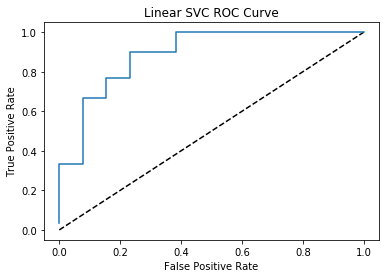

0.0 0.0333333333333
0.0 0.333333333333
0.0769230769231 0.333333333333
0.0769230769231 0.666666666667
0.153846153846 0.666666666667
0.153846153846 0.766666666667
0.230769230769 0.766666666667
0.230769230769 0.9
0.384615384615 0.9
0.384615384615 1.0
1.0 1.0


In [22]:
plot_roc(best5.best_estimator_, X_test5, Y_test5)

## 6. MSA (positive) vs PSP (negative)

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  85 out of 100 | elapsed:    6.1s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.1s finished


Best parameters set found on development set:

{'classifier__C': 0.01438449888287663}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.89      0.83      0.86        30
          1       0.67      0.77      0.71        13

avg / total       0.82      0.81      0.82        43


Confusion matrix, without normalization
[[25  5]
 [ 3 10]]

recall	0.769230769231
precision	0.666666666667
auc	0.801282051282
specificity	0.833333333333
npv	0.892857142857
accuracy	0.813953488372
weighted_sensitivity	0.769230769231
weighted_ppv	0.821917808219
weighted_specificity	0.833333333333
weighted_npv	0.78313253012
weighted_accuracy	0.801282051282
TRAINNG PROBABILITIES
0 0.203146304623
1 0.876001436948
1 0.528261534789
0 0.0962905715998
0 0.0223340870532
0 0.0962666583538
0 0.276775410467
1 0.82431942134
0 0.0962070314984
0 0.240190590594


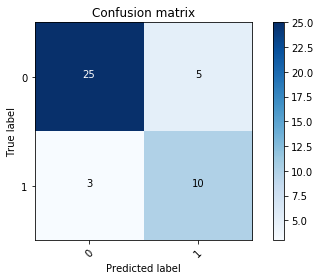

In [23]:
# Get the data
data6 = group_classes(_data, {2:1, 3:0})

y6 = data6['GroupID']
X6 = data6.drop(['GroupID'], axis=1)

X_train6, X_test6, Y_train6, Y_test6 = train_test_split(X6, y6, test_size=_test_size, random_state=_random_seed)

best6 = grid_search_optimization(clf, param_grid, X_train6, Y_train6, X_test6, Y_test6, cv=_cv, scoring=_scoring)

In [24]:
scores = cross_validate(best4.best_estimator_, X_train6, Y_train6, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.0200974464417	0.0052513644324
score_time	0.0149166107178	0.00290058714412
test_recall	0.844761904762	0.0837120645461
train_recall	0.926065162907	0.0069092976201
test_precision	0.761073044602	0.0800102134348
train_precision	0.807609202392	0.0263017188031
test_auc	0.821591478697	0.045899907024
train_auc	0.883538910568	0.0147196150524
test_specificity	0.798421052632	0.104173305421
train_specificity	0.841012658228	0.0264747675188
test_npv	0.883176493269	0.0497003738665
train_npv	0.940611958977	0.00617064015203
test_accuracy	0.817249809015	0.0514080911647
train_accuracy	0.876521873956	0.0166049885428
test_weighted_sensitivity	0.844761904762	0.0837120645461
train_weighted_sensitivity	0.926065162907	0.0069092976201
test_weighted_ppv	0.81547537383	0.0642290392606
train_weighted_ppv	0.853935819915	0.0209731435778
test_weighted_specificity	0.798421052632	0.104173305421
train_weighted_specificity	0.841012658228	0.0264747675188
test_weighted_npv	0.845639649593	0.0632221922384
train_weig

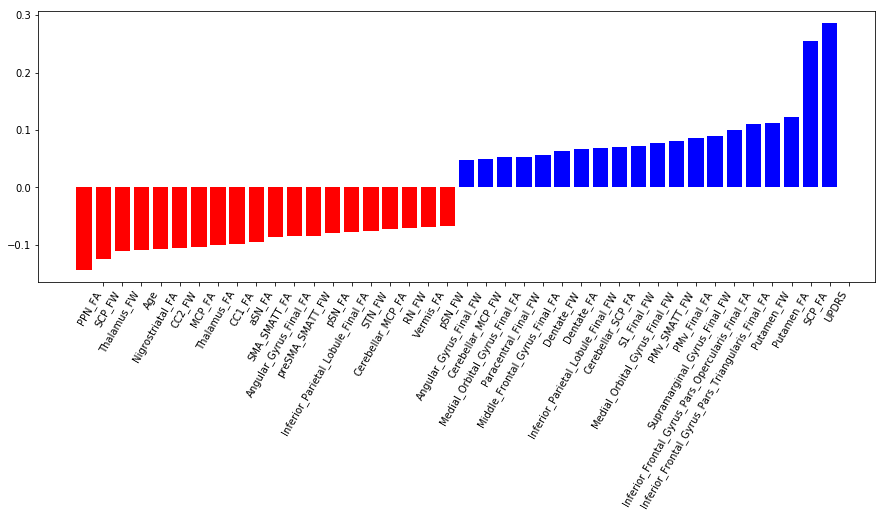

Age	-0.108562603164
Sex	-0.0408516579388
UPDRS	0.286349950227
aSN_FA	-0.0954438534258
Caudate_FA	-0.0322864790171
CC2_FA	-0.00172760764151
GP_FA	-0.00954518706215
LobuleVI_FA	-0.0297085575426
LobuleV_FA	0.0136613754443
MCP_FA	-0.104393043575
pSN_FA	-0.0795578851702
Putamen_FA	0.122039581857
SCP_FA	0.254250959995
STN_FA	-0.0161172800865
Thalamus_FA	-0.100683303615
Vermis_FA	-0.0682825709486
RN_FA	0.0234128414889
PPN_FA	-0.143771239025
Dentate_FA	0.0667344027472
CC1_FA	-0.0985769457676
aSN_FW	-0.0331665231589
Caudate_FW	8.18830865826e-05
CC2_FW	-0.104960600782
GP_FW	0.0122051527045
LobuleVI_FW	0.0116113645968
LobuleV_FW	0.0261850050306
MCP_FW	0.0246455967848
pSN_FW	-0.0677457727315
Putamen_FW	0.112676951501
SCP_FW	-0.123889590986
STN_FW	-0.0753513279328
Thalamus_FW	-0.11126913934
Vermis_FW	0.0446949715765
RN_FW	-0.0701904069458
PPN_FW	-0.049044901518
Dentate_FW	0.0637121722329
CC1_FW	-0.0391146234496
Angular_Gyrus_Final_FA	-0.0851199025045
Anterior_Orbital_Gyrus_Final_FA	0.0156846244984


In [25]:
model = best6.best_estimator_.named_steps['classifier']
feature_names = data6.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

             precision    recall  f1-score   support

          0       0.89      0.83      0.86        30
          1       0.67      0.77      0.71        13

avg / total       0.82      0.81      0.82        43

TESTING PROBABILITIES
1 0.978484391145
0 0.0378680379904
0 0.735935281258
1 0.323530014355
1 0.89856023811
0 0.00817450049682
1 0.0291969227044
1 0.643337771486
0 0.0243252412367
0 0.529184459826
0 0.33787456326
0 0.0605863059552
0 0.309621207436
1 0.134915091192
1 0.918837014713
0 0.00209335098567
0 0.730941888801
0 0.0336427720739
0 0.0572576638686
0 0.0030376396158
1 0.676793139127
0 0.02663566148
0 0.197949487246
1 0.952060829965
0 0.00645691832817
0 0.0658528617766
0 0.0472336322944
0 0.712740624491
0 0.00445284017932
0 0.0463030313809
0 0.54909188257
1 0.938192247137
0 0.33911603256
1 0.969514067506
0 0.00247330051029
1 0.964814666831
0 0.0619110136904
0 0.0809706663307
0 0.13451527994
0 0.0205376817236
1 0.799002920861
0 0.00475275132881
0 0.209856961875


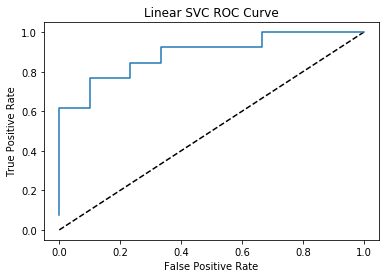

0.0 0.0769230769231
0.0 0.615384615385
0.1 0.615384615385
0.1 0.769230769231
0.233333333333 0.769230769231
0.233333333333 0.846153846154
0.333333333333 0.846153846154
0.333333333333 0.923076923077
0.666666666667 0.923076923077
0.666666666667 1.0
1.0 1.0


In [26]:
plot_roc(best6.best_estimator_, X_test6, Y_test6)

In [27]:
print("Control (0) vs All Parkinsons(1)")
print("TRAIN/VALIDATION")
print(Y_train1.value_counts())
print("TEST")
print(Y_test1.value_counts())
print()
print("=====================================")
print()
print("2. PD(0) vs MSA/PSP(1)")
print("TRAIN/VALIDATION")
print(Y_train2.value_counts())
print("TEST")
print(Y_test2.value_counts())
print()
print("=====================================")
print()
print("MSA (0) vs PD/PSP(1)")
print("TRAIN/VALIDATION")
print(Y_train3.value_counts())
print("TEST")
print(Y_test3.value_counts())
print()
print("=====================================")
print()
print("PSP (0) vs MSA/PD (1)")
print("TRAIN/VALIDATION")
print(Y_train4.value_counts())
print("TEST")
print(Y_test4.value_counts())
print("=====================================")
print()
print("MSA (0) vs PSP(1)")
print("TRAIN/VALIDATION")
print(Y_train5.value_counts())
print("TEST")
print(Y_test5.value_counts())
print()
print("=====================================")
print()
print("PSP (0) vs MSA(1)")
print("TRAIN/VALIDATION")
print(Y_train6.value_counts())
print("TEST")
print(Y_test6.value_counts())
print()


Control (0) vs All Parkinsons(1)
TRAIN/VALIDATION
1    578
0    223
Name: GroupID, dtype: int64
TEST
1    146
0     55
Name: GroupID, dtype: int64


2. PD(0) vs MSA/PSP(1)
TRAIN/VALIDATION
0    406
1    173
Name: GroupID, dtype: int64
TEST
0    105
1     40
Name: GroupID, dtype: int64


MSA (0) vs PD/PSP(1)
TRAIN/VALIDATION
0    509
1     70
Name: GroupID, dtype: int64
TEST
0    131
1     14
Name: GroupID, dtype: int64


PSP (0) vs MSA/PD (1)
TRAIN/VALIDATION
0    476
1    103
Name: GroupID, dtype: int64
TEST
0    119
1     26
Name: GroupID, dtype: int64

MSA (0) vs PSP(1)
TRAIN/VALIDATION
1    99
0    71
Name: GroupID, dtype: int64
TEST
1    30
0    13
Name: GroupID, dtype: int64


PSP (0) vs MSA(1)
TRAIN/VALIDATION
0    99
1    71
Name: GroupID, dtype: int64
TEST
0    30
1    13
Name: GroupID, dtype: int64



In [28]:
import pickle
mod_name = 'both'
pickle.dump(best1, open('./models/%s/park_v_control.pkl' %mod_name, 'wb'))
pickle.dump(best2, open('./models/%s/pd_v_atypical.pkl' %mod_name, 'wb'))
pickle.dump(best3, open('./models/%s/msa_v_pd_psp.pkl' %mod_name, 'wb'))
pickle.dump(best4, open('./models/%s/psp_v_pd_msa.pkl' %mod_name, 'wb'))
pickle.dump(best5, open('./models/%s/psp_v_msa.pkl' %mod_name, 'wb'))